In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import keras
random.seed(42)

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = (70, 70)
def process_image(image_location):
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
           
    return resized_image

In [3]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    for fol in os.listdir(data_path):
        fol_path = os.path.join(data_path, fol)
        if os.path.isdir(fol_path):
            for file in os.listdir(fol_path):
                if ".jpg" in file:
                    label = -1

                    if fol[0] == "b":
                        label = 0
                    elif fol[0] == "w":
                        label = 1
                    elif fol == "empty":
                        label = 2

                    if label != -1:
                        complete_file_loc = os.path.join(fol_path, file)
                        grayscale_image = process_image(complete_file_loc)
                        features_with_labels.append({"feature": grayscale_image, "label": label})
            
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]

    return np.array(X), np.array(y)

In [4]:
X_test, y_test = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\Chess ID Public Data\\test")

print(X_test.shape)
print(y_test.shape)

(189, 70, 70, 3)
(189,)


In [13]:
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import set_random_seed
set_random_seed(42)

In [6]:
# batch size
batch_size = 64

required_input_shape = (*IMAGE_SIZE, 3)

In [7]:
model_folder_name = "models"
tensorboard_logs_folder_location = "logs"

In [9]:
def load_3_class_cnn_model(model_weights_file_name):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.summary()

    
    # load the model weights
    model.load_weights(os.path.join(model_folder_name, model_weights_file_name))
                           
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [19]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values):
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    
    num_failed_images = len(mis_prediction_indices)
    num_images_per_row = IMAGES_PER_ROW
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)

    print(num_failed_images)
    print(num_rows)
    print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break

            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]])
            axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
__________

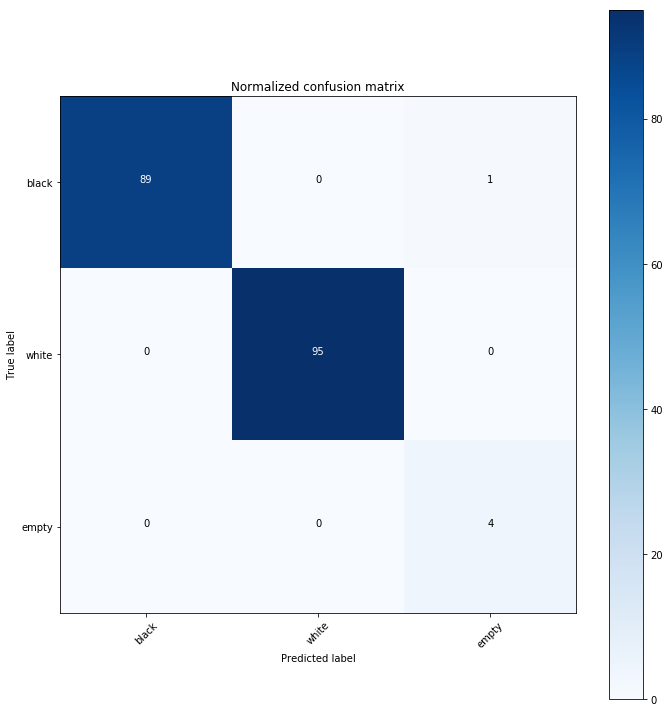

In [14]:
trained_model = load_3_class_cnn_model("custom_cnn_color_99.hdf5")
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["black", "white", "empty"]
test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

Confusion matrix, without normalization
[[ 6  0  1]
 [ 0  9  0]
 [15  3 30]]
0.703125


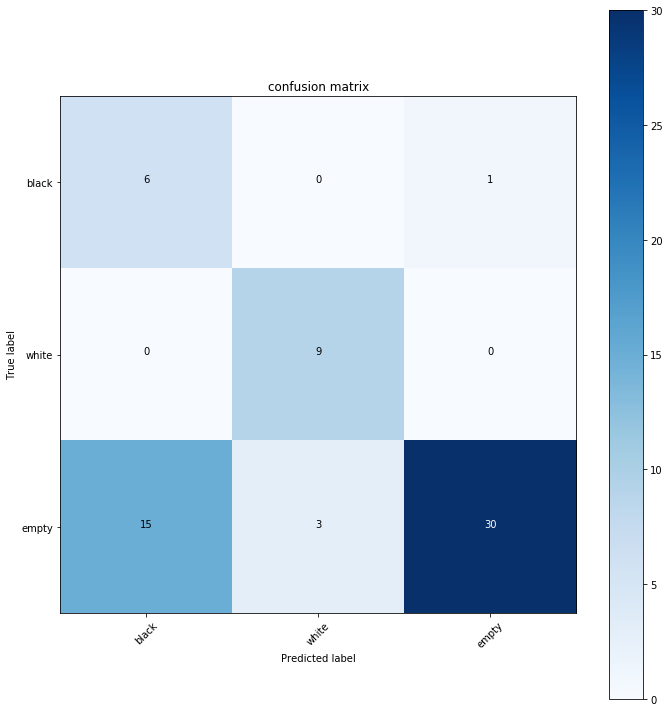

In [16]:
X_test1, y_test1 = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images")
test_predictions1 = trained_model.predict(X_test1, batch_size=batch_size)
y_test_pred1 = [np.argmax(x) for x in test_predictions1]
cnf_matrix1 = confusion_matrix(y_test1, y_test_pred1)
plot_confusion_matrix(cnf_matrix1, classes=class_names, normalize=False,title='confusion matrix')
print(accuracy_score(y_test1, y_test_pred1))

19
4
5


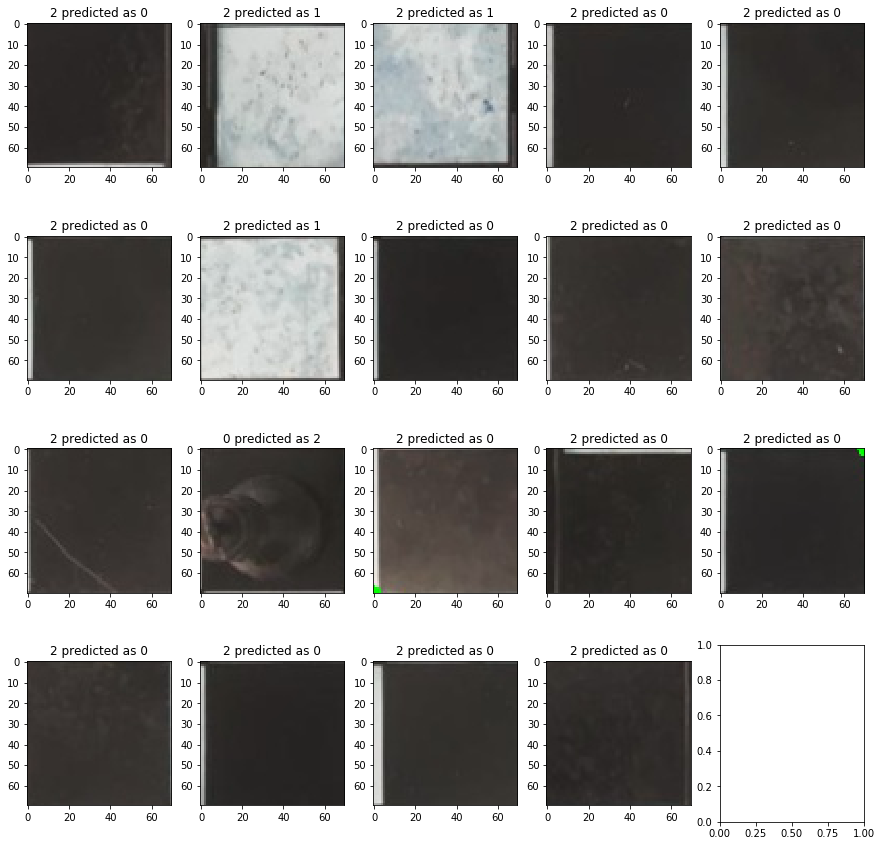

In [20]:
plot_mispredicted_images(X_test1, y_test1, y_test_pred1)